# Boundary Value Problems

## Contents

- [Example: Simple Pendulum](#example_simple_pendulum)

## Mass-Matrix DAEs <a id="mass_matrix_DAEs" />

In this example, we will solve the ODE that satisfies the boundary condition in the form of

```math
\begin{aligned}
\frac{du}{dt} = f(t,u) \\
g(u) = \vec{0}
\end{aligned}
```

## Example: Simple Pendulum <a id="simple_pendulum" />

The concrete example that we are solving is the simple pendulum $\ddot{u}+\frac{g}{L}sin(u)=0$ on the time interval $t\in[0,\frac{\pi}{2}]$. 

First, we need to define the ODE

In [5]:
using BoundaryValueDiffEq, Plots

const g = 9.81
L = 1.0
tspan = (0.0, pi / 2)

function simplependulum!(du, u, p, t)
    θ = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g / L) * sin(θ)
end

simplependulum! (generic function with 1 method)

### Boundary Condition

There are two problem types available:

  - A problem type for general boundary conditions `BVProblem` (including conditions that may be anywhere/everywhere on the integration interval).
  - A problem type for boundaries that are specified at the beginning and the end of the integration interval `TwoPointBVProblem`

#### `BVProblem`

The boundary conditions are specified by a function that calculates the residual in-place from the problem solution, such that the residual is $\vec{0}$ when the boundary condition is satisfied.

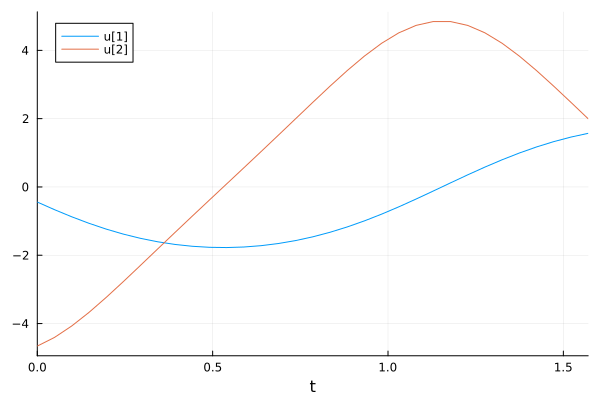

In [6]:
function bc1!(residual, u, p, t)
    residual[1] = u[end ÷ 2][1] + pi/2        # the solution at the middle of the time span should be -pi/2
    residual[2] = u[end][1] - pi/2            # the solution at the end of the time span should be pi/2
end

bvp1 = BVProblem(simplependulum!, bc1!, [pi / 2, pi / 2], tspan)
sol1 = solve(bvp1, MIRK4(), dt = 0.05)
plot(sol1)

The third argument of `BVProblem`  is the initial guess of the solution, which is constant in this example.

We need to use `MIRK4` or `Shooting` methods to solve `BVProblem`. `MIRK4` is a collocation method, whereas `Shooting` treats the problem as an IVP and varies the initial conditions until the boundary conditions are met.
If you can have a good initial guess, `Shooting` method works very well.

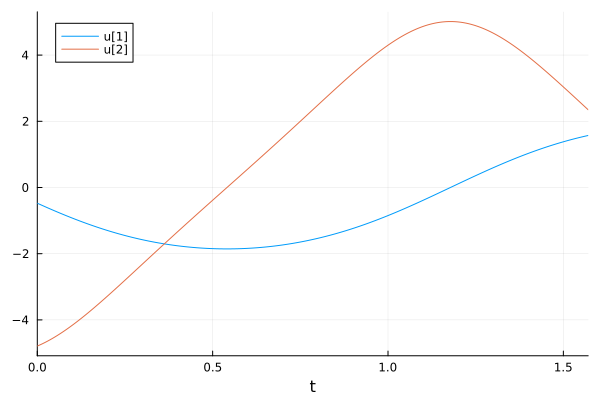

In [ ]:
using OrdinaryDiffEq
u₀_2 = [-1.6, -1.7]                             # the initial guess
function bc3!(residual, sol, p, t)
    residual[1] = sol(pi / 4)[1] + pi / 2       # use the interpolation here, since indexing will be wrong for adaptive methods
    residual[2] = sol(pi / 2)[1] - pi / 2
end
bvp3 = BVProblem(simplependulum!, bc3!, u₀_2, tspan)
sol3 = solve(bvp3, Shooting(Vern7()))
plot(sol3)

The initial guess can also be supplied via a function of `t` or a previous solution type, this is especially handy for parameter analysis.
We changed `u` to `sol` to emphasize the fact that in this case, the boundary condition can be written on the solution object. Thus, all the features on the solution type such as interpolations are available when using the `Shooting` method. (i.e. you can have a boundary condition saying that the maximum over the interval is `1` using an optimization function on the continuous output). Note that user has to import the IVP solver before it can be used. Any common interface ODE solver is acceptable.

#### `TwoPointBVProblem`

`TwoPointBVProblem` is operationally the same as `BVProblem` but allows for the solver
to specialize on the common form of being a two-point BVP, i.e. a BVP which only has
boundary conditions at the start and the finish of the time interval.
Defining a similar problem as `TwoPointBVProblem` is shown in the following example:

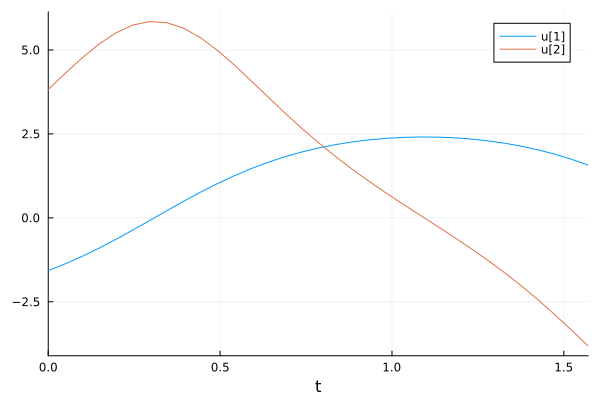

In [11]:
function bc2a!(resid_a, u_a, p)             # u_a is at the beginning of the time span
    resid_a[1] = u_a[1] + pi / 2            # the solution at the beginning of the time span should be -pi/2
end
function bc2b!(resid_b, u_b, p)             # u_b is at the ending of the time span
    resid_b[1] = u_b[1] - pi / 2            # the solution at the end of the time span should be pi/2
end
bvp2 = TwoPointBVProblem(simplependulum!, (bc2a!, bc2b!), [pi / 2, pi / 2], tspan;
    bcresid_prototype = (zeros(1), zeros(1)))
sol2 = solve(bvp2, MIRK4(), dt = 0.05)
plot(sol2)